# King County Home Sale Price Model
The following project was written by Max Tejera in the fall of 2023 and was revised during the summer of 2024. It uses data sourced from __[Kaggle](https://www.kaggle.com/datasets/andykrause/kingcountysales)__ to test different house price forecasting models.

# Section 0: Setup
Importing relevant libraries.

In [1]:
# Import relevant modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.cm as cm
import statsmodels.api as sm
import sqlite3
import plotly.express as px
import calendar
import kaggle
import os
import zipfile
from matplotlib.ticker import FuncFormatter
from sklearn.metrics import accuracy_score, recall_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error, make_scorer
import geopandas as gpd
from shapely.geometry import Point
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.colors import Normalize

# Section 1: Data Load and EDA

The following code calls a CSV file from the Kaggle API.

In [2]:
# Define the dataset identifier and the path to download the dataset
dataset_identifier = 'andykrause/kingcountysales/'
download_path = 'C:\\Users\\tejer\\OneDrive\\Desktop\\Revelio\\KCHomesales'

# Download the dataset using Kaggle API
kaggle.api.dataset_download_files(dataset_identifier, path=download_path, unzip=False)

In [3]:
# Define the path to the downloaded zip file
zip_file_path = os.path.join(download_path, f'{dataset_identifier.split("/")[1]}.zip')

# Check if the zip file is already downloaded
if not os.path.exists(zip_file_path):
    # If not, download the dataset using Kaggle API
    kaggle.api.dataset_download_files(dataset_identifier, path=download_path, unzip=False)

# Check if the files are already extracted
if not any(fname.endswith('.csv') for fname in os.listdir(download_path)):
    # Unzip the dataset
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall(download_path)

# List the files to check the extracted files
extracted_files = os.listdir(download_path)
print(f"Extracted files: {extracted_files}")

Extracted files: ['.ipynb_checkpoints', 'King County Home Sales Model.ipynb', 'kingcountysales.zip', 'kingcountysales_2000_2023.csv']


In [4]:
# Load CSV file and view dataset shape

df = pd.read_csv('C:\\Users\\tejer\\OneDrive\\Desktop\\Revelio\\KCHomesales\\kingcountysales_2000_2023.csv')

# Print head

print(df.head())

   Unnamed: 0    sale_id          pinx   sale_date  sale_price  sale_nbr  \
0           1  1999..144  ..2734100475  1999-01-05      150000       1.0   
1           2  1999..258  ..1535200725  1999-01-05      235000       1.0   
2           3  1999..331  ..6028000255  1999-01-04      293000       1.0   
3           4  1999..609  ..1238501101  1999-01-11      178506       1.0   
4           5  1999..775  ..1939800005  1999-01-07      270000       1.0   

  sale_warning join_status  join_year   latitude  ...  view_olympics  \
0                     demo       1999  47.544359  ...              0   
1                     demo       1999  47.421247  ...              0   
2                     demo       1999  47.572103  ...              0   
3                     demo       1999  47.685567  ...              0   
4                     demo       1999  47.764482  ...              0   

   view_cascades view_territorial view_skyline view_sound  view_lakewash  \
0              0                0 

# Section 2: Exploratory Data Analysis

The following section evaluates the shape of the data set and the properties of some of the variables.

In [5]:
# Print data shape

num_rows, num_columns = df.shape
print(f"The dataset has {num_rows} rows and {num_columns} columns.")

The dataset has 575319 rows and 49 columns.


In [6]:
# Check for missing values in data
missing_values = df.isna().sum()
print('Number of missing values per variable:')
print(missing_values)
print()
print('Percentage of values missing:')
missing_percentage = (df.isna().sum() / len(df)) * 100
print(missing_percentage)
print()

# View unique values in data

print('Unique values of categorical variables:')
for col in df.columns:
    unique_vals = df[col].nunique()
    if unique_vals < 20: # Assuming no categorical variable has more than 20 unique values
        print(f"{col} has {unique_vals} unique values: {df[col].unique()}")

Number of missing values per variable:
Unnamed: 0               0
sale_id                  0
pinx                     0
sale_date                0
sale_price               0
sale_nbr            125559
sale_warning             0
join_status              0
join_year                0
latitude                 0
longitude                0
area                     0
city                     0
zoning                   0
subdivision          51132
present_use              0
land_val                 0
imp_val                  0
year_built               0
year_reno                0
sqft_lot                 0
sqft                     0
sqft_1                   0
sqft_fbsmt               0
grade                    0
fbsmt_grade              0
condition                0
stories                  0
beds                     0
bath_full                0
bath_3qtr                0
bath_half                0
garb_sqft                0
gara_sqft                0
wfnt                     0
golf            

# Section 2: Correlation Analysis

The following section calculates and evaluates the correlation of variables with the variable of interest, sale_price.

In [7]:
# Convert sale date to datetime sub-variables

# Check if 'sale_date' column exists
if 'sale_date' in df.columns:
    # Convert the 'sale_date' column to datetime format with the correct format
    df['sale_date'] = pd.to_datetime(df['sale_date'], format='%Y-%m-%d')

    # From date, create year, month, day, and weekday columns
    df['year'] = df['sale_date'].dt.year
    df['month'] = df['sale_date'].dt.month
    df['day'] = df['sale_date'].dt.day
    df['weekday'] = df['sale_date'].dt.weekday
    df = df.drop(columns=['sale_date'])
else:
    print("The 'sale_date' column does not exist in the DataFrame.")

In [8]:
# View price correlations of variables with price

correlation_matrix = df.corr()
price_correlation = correlation_matrix['sale_price'].sort_values(ascending=False)
print(price_correlation)

C:\Users\tejer\AppData\Local\Temp\ipykernel_25692\182415024.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = df.corr()


sale_price          1.000000
land_val            0.483447
sqft                0.448000
year                0.441218
imp_val             0.439029
grade               0.433904
sqft_1              0.322242
view_lakewash       0.305239
view_territorial    0.264558
latitude            0.233145
sale_nbr            0.231383
Unnamed: 0          0.220248
beds                0.201019
bath_full           0.198873
sqft_fbsmt          0.197604
wfnt                0.181986
bath_3qtr           0.180293
stories             0.167367
fbsmt_grade         0.152333
view_olympics       0.140185
view_skyline        0.136236
bath_half           0.134027
gara_sqft           0.126354
view_lakesamm       0.118798
year_reno           0.116747
view_cascades       0.104386
view_sound          0.103458
sqft_lot            0.082911
view_other          0.069740
view_rainier        0.053631
greenbelt           0.040522
golf                0.039562
longitude           0.039546
year_built          0.036786
view_otherwate

It appears no single variable has a correlation in excess of 50%. The order of the correlation appears to make sense. Land value, square footage, and improvement value have the larges impact on sale price.

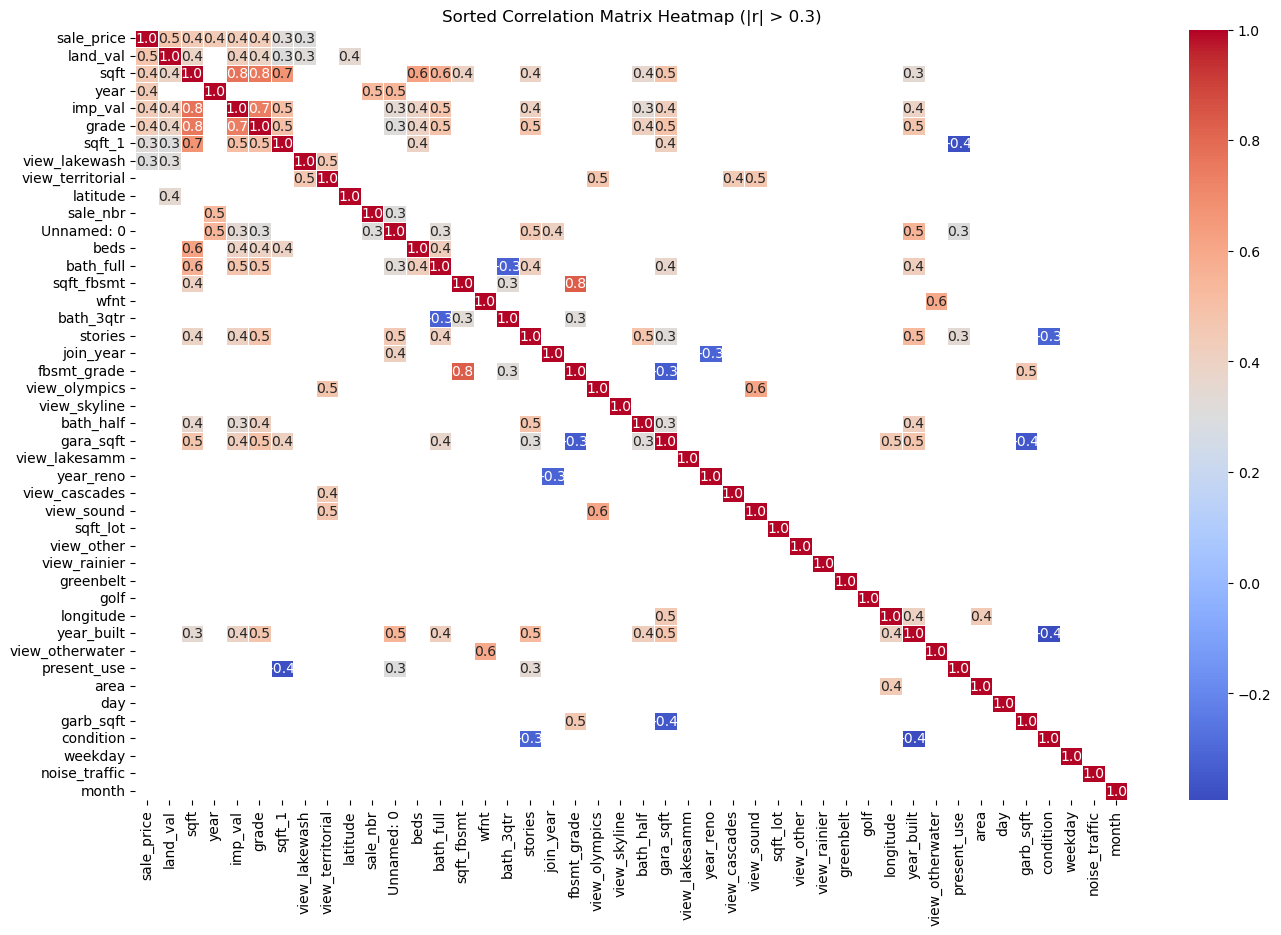

In [9]:
# Re-order correlations and set relevance threshold to 30% before viewing as correlation matrix
sorted_columns = correlation_matrix.abs().sort_values(by='sale_price', ascending=False).index.tolist()
sorted_corr_matrix = correlation_matrix[sorted_columns].reindex(sorted_columns)
threshold = 0.3
mask = (sorted_corr_matrix.abs() < threshold)

plt.figure(figsize=(16, 10))
sns.heatmap(sorted_corr_matrix, annot=True, fmt=".1f", cmap='coolwarm', linewidths=.5, mask=mask)
plt.title('Sorted Correlation Matrix Heatmap (|r| > 0.3)')
plt.show()

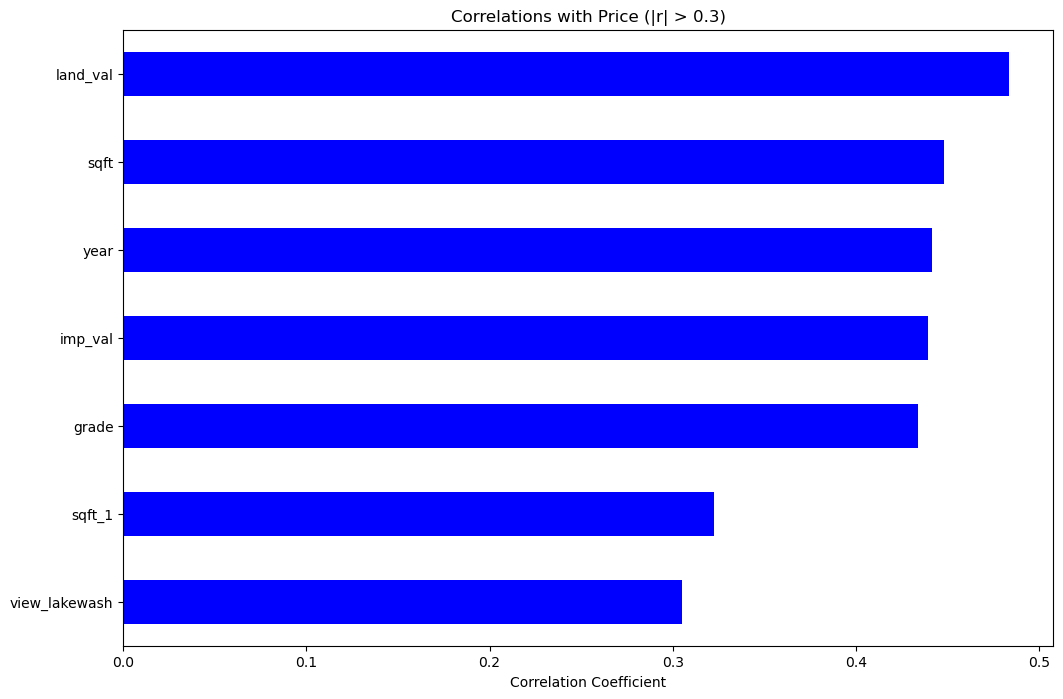

In [10]:
# View simpler bar chart of correlations

correlations_with_price = sorted_corr_matrix['sale_price'].drop('sale_price')
filtered_correlations = correlations_with_price[correlations_with_price.abs() > threshold]
plt.figure(figsize=(12, 8))
filtered_correlations.sort_values().plot(kind='barh', color='blue')  # 'barh' creates a horizontal bar plot
plt.title('Correlations with Price (|r| > 0.3)')
plt.xlabel('Correlation Coefficient')
plt.show()

# Section 3: Sale Price Distribution Visualization

The following section provides two plots. The first shows the skew in sale_price - there are a few major outliers in sale price. The next chart zooms into the bulk of the distribution, homes with prices below $5 million. The third chart shows how homes with higher square footage tend to have higher grades and sale prices.

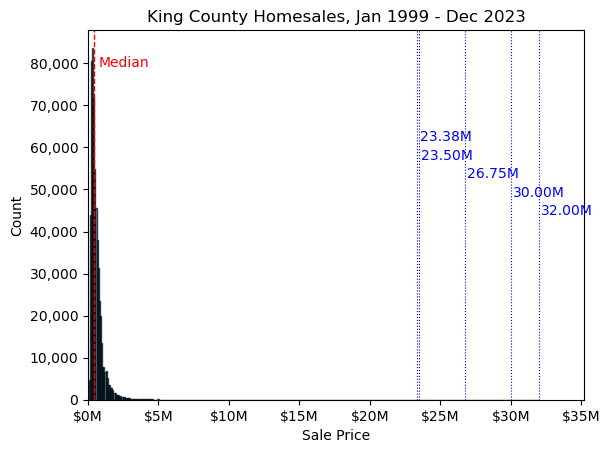

In [11]:
# View histogram of price

price = df["sale_price"]

# Calculate the median and top 5 prices
median_price = np.median(price)
top_5_prices = sorted(price)[-5:]

# Plot histogram
plt.hist(price, bins=400, edgecolor="k", alpha=0.7)

# Plot vertical line for median
plt.axvline(median_price, color='r', linestyle='dashed', linewidth=1)
plt.text(median_price + (price.max() - price.min())*0.01, plt.ylim()[1]*0.9, 'Median', color='r')

# Plot vertical lines and stagger labels for top 5 prices
y_position = plt.ylim()[1]*0.7
increment = plt.ylim()[1]*0.05
for p in top_5_prices:
    plt.axvline(p, color='b', linestyle='dotted', linewidth=0.8)
    plt.text(p + (price.max() - price.min())*0.005, y_position, f"{p*1e-6:.2f}M", color='b')
    y_position -= increment

# Improve axis formatting

def millions_formatter(x, pos):
    return f'${x*1e-6:.0f}M'

formatter = FuncFormatter(millions_formatter)
plt.gca().xaxis.set_major_formatter(formatter)
plt.xlim(0, 9e6)

# Dynamically set x-axis limit to a bit more than the maximum price
plt.xlim(0, price.max() * 1.1)

# Add commas to Y-axis
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda x, _: '{:,.0f}'.format(x)))

# Set title and labels
plt.title("King County Homesales, Jan 1999 - Dec 2023")
plt.xlabel("Sale Price")
plt.ylabel("Count")

# Display
plt.show()

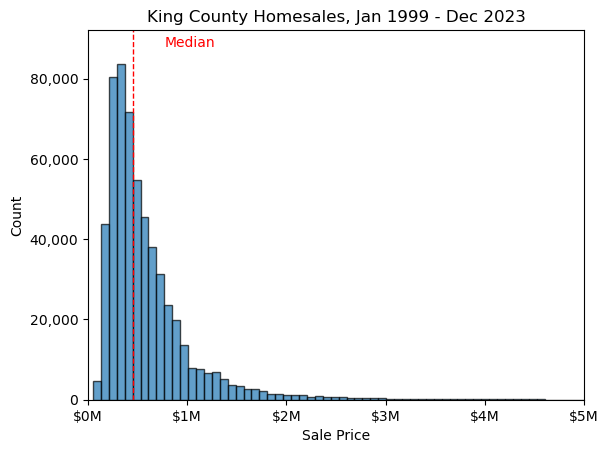

In [12]:
# Plot histogram
counts, bins, patches = plt.hist(price, bins=400, edgecolor="k", alpha=0.7)

# Plot vertical line for median
plt.axvline(median_price, color='r', linestyle='dashed', linewidth=1)
plt.text(median_price + (price.max() - price.min())*0.01, max(counts)*1.05, 'Median', color='r')

# Improve axis formatting
def millions_formatter(x, pos):
    return f'${x*1e-6:.0f}M'

formatter = FuncFormatter(millions_formatter)
plt.gca().xaxis.set_major_formatter(formatter)

# Set X-axis limit to $5M
plt.xlim(0, 5e6)

# Set Y-axis limit to 110% of the max Y value
plt.ylim(0, max(counts) * 1.1)

# Add commas to Y-axis
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda x, _: '{:,.0f}'.format(x)))

# Set title and labels
plt.title("King County Homesales, Jan 1999 - Dec 2023")
plt.xlabel("Sale Price")
plt.ylabel("Count")

# Display
plt.show()

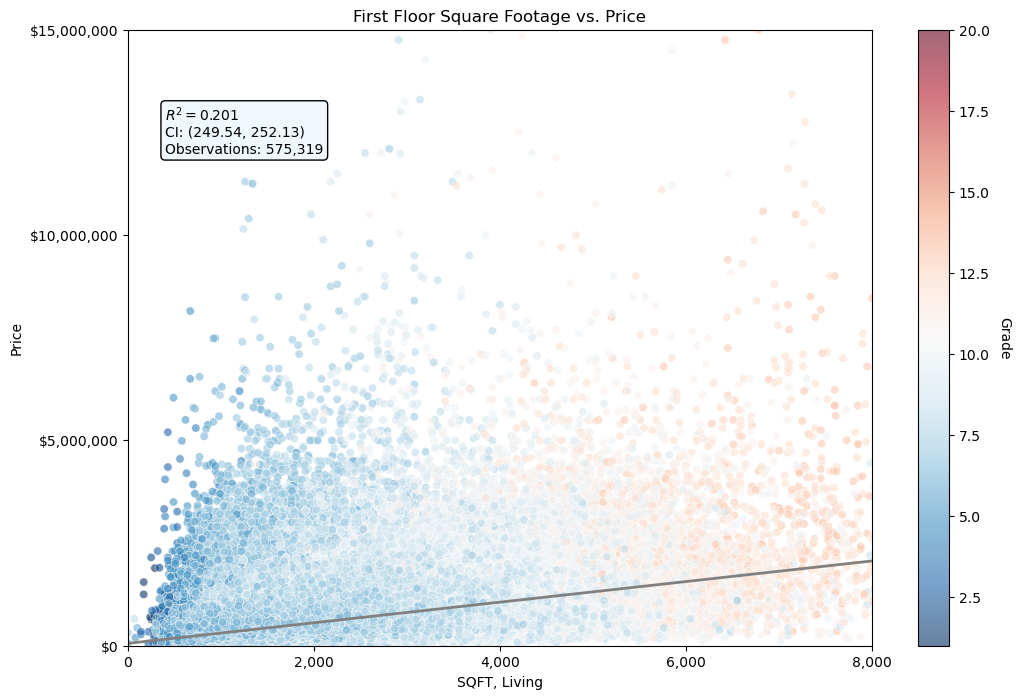

In [13]:
# Define variables to graph
x_data = df['sqft']
y_data = df['sale_price']
color_data = df['grade']

# Normalize grade values for color mapping
norm_color = cm.colors.Normalize(vmin=color_data.min(), vmax=color_data.max())
colormap = cm.RdBu_r

# Plot graph
plt.figure(figsize=(12, 8))
plt.scatter(x_data, y_data, 
            c=color_data, cmap=colormap, norm=norm_color, 
            edgecolors="w", linewidth=0.5, alpha=0.6)  # Add alpha for opacity

cbar = plt.colorbar()
cbar.set_label('Grade', rotation=270, labelpad=15) # Rotate for better visibility

# Compute linear regression using statsmodels
X = sm.add_constant(x_data)  # Add intercept to model
model = sm.OLS(y_data, X)
results = model.fit()

# Plot trendline
sns.regplot(x=x_data, y=y_data, scatter=False, color='gray', line_kws={'linewidth':2})

# Format the Y-axis tick labels
y_ticks = plt.yticks()[0]
plt.yticks(ticks=np.arange(0, 15000001, 5000000), labels=['${:,.0f}'.format(tick) for tick in np.arange(0, 15000001, 5000000)])

# Adjust the X and Y-axis limits
plt.xlim(0, 8000)
plt.ylim(0, 15000000)

# Define a function for formatting with commas for X-axis
def thousand_comma_formatter(x, pos):
    return f'{int(x):,}'

# Create the formatter and apply it to the X-axis
x_formatter = FuncFormatter(thousand_comma_formatter)
plt.gca().xaxis.set_major_formatter(x_formatter)
plt.xticks(ticks=np.arange(0, 8001, 2000))

# Display summary statistics inside plot
summary_text = (
    f"$R^2 = {results.rsquared:.3f}$\n"
    f"CI: ({results.conf_int().iloc[1, 0]:.2f}, {results.conf_int().iloc[1, 1]:.2f})\n"
    f"Observations: {len(x_data):,}"
)
plt.annotate(summary_text, xy=(0.05, 0.8), xycoords='axes fraction', 
             bbox=dict(boxstyle="round,pad=0.3", edgecolor="black", facecolor="aliceblue"))

plt.title('First Floor Square Footage vs. Price')
plt.xlabel('SQFT, Living')
plt.ylabel('Price')
plt.show()

# Section 4: Forecasting Model

The following section produces both standard linear regression and K-Nearest Neighbor (KNN) models to forecast sale price. Certain variables must be dropped for the KNN model to run. Most of them are irrelevant.

In [14]:
# Print the columns of the DataFrame to check for 'sale_date'
print("Columns in DataFrame:", df.columns)

Columns in DataFrame: Index(['Unnamed: 0', 'sale_id', 'pinx', 'sale_price', 'sale_nbr',
       'sale_warning', 'join_status', 'join_year', 'latitude', 'longitude',
       'area', 'city', 'zoning', 'subdivision', 'present_use', 'land_val',
       'imp_val', 'year_built', 'year_reno', 'sqft_lot', 'sqft', 'sqft_1',
       'sqft_fbsmt', 'grade', 'fbsmt_grade', 'condition', 'stories', 'beds',
       'bath_full', 'bath_3qtr', 'bath_half', 'garb_sqft', 'gara_sqft', 'wfnt',
       'golf', 'greenbelt', 'noise_traffic', 'view_rainier', 'view_olympics',
       'view_cascades', 'view_territorial', 'view_skyline', 'view_sound',
       'view_lakewash', 'view_lakesamm', 'view_otherwater', 'view_other',
       'submarket', 'year', 'month', 'day', 'weekday'],
      dtype='object')


In [15]:
# Create a new DataFrame for KNN that omits certain columns
columns_to_drop = ['sale_id', 'pinx', 'Unnamed: 0', 'sale_warning', 'latitude', 'longitude','subdivision','present_use','submarket','sale_nbr','join_status','zoning']
df_knn = df.drop(columns=[col for col in columns_to_drop if col in df.columns])

In [16]:
# Identify categorical variables to be encoded
categorical_vars = ['city']

# Apply one-hot encoding to categorical variables and drop original categorical columns
df_knn = pd.get_dummies(df_knn, columns=categorical_vars, drop_first=True)

In [17]:
# Define features and target variable
X = df_knn.drop('sale_price', axis=1)
y = df_knn['sale_price']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

# Select numerical columns to scale from training data
num_cols = X_train.select_dtypes(include=['float64', 'int64']).columns

# Fit the scaler on the training data. Transform both training and test data
scaler = StandardScaler()
X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
X_test[num_cols] = scaler.transform(X_test[num_cols])

In [18]:
# Print the columns being input into the model
print("Columns being input into the model:", X_train.columns.tolist())

Columns being input into the model: ['join_year', 'area', 'land_val', 'imp_val', 'year_built', 'year_reno', 'sqft_lot', 'sqft', 'sqft_1', 'sqft_fbsmt', 'grade', 'fbsmt_grade', 'condition', 'stories', 'beds', 'bath_full', 'bath_3qtr', 'bath_half', 'garb_sqft', 'gara_sqft', 'wfnt', 'golf', 'greenbelt', 'noise_traffic', 'view_rainier', 'view_olympics', 'view_cascades', 'view_territorial', 'view_skyline', 'view_sound', 'view_lakewash', 'view_lakesamm', 'view_otherwater', 'view_other', 'year', 'month', 'day', 'weekday', 'city_AUBURN', 'city_BEAUX ARTS', 'city_BELLEVUE', 'city_BLACK DIAMOND', 'city_BOTHELL', 'city_BURIEN', 'city_CARNATION', 'city_CLYDE HILL', 'city_COVINGTON', 'city_DES MOINES', 'city_DUVALL', 'city_ENUMCLAW', 'city_FEDERAL WAY', 'city_HUNTS POINT', 'city_ISSAQUAH', 'city_KENMORE', 'city_KENT', 'city_KING COUNTY', 'city_KIRKLAND', 'city_LAKE FOREST PARK', 'city_MAPLE VALLEY', 'city_MEDINA', 'city_MERCER ISLAND', 'city_MILTON', 'city_NEWCASTLE', 'city_NORMANDY PARK', 'city_NO

The following code designs a function to evaluate how effective a KNN model fit using the inputs and different levels of K. I show the results for evaluating K=9, K=10, and K=11. From prior iterations of running this code I know that K=10 had the maximum R-squared value amongst K=3 through K=11.

In [19]:
# Define a function for evaluating the KNN model
def eval_knn(X_train, y_train, X_test, y_test, k):
    # Train KNN regressor
    knn_regressor = KNeighborsRegressor(n_neighbors=k)
    knn_regressor.fit(X_train, y_train)
    y_pred = knn_regressor.predict(X_test)
    
    # Calculate and print metrics
    mse = mean_squared_error(y_test, y_pred)
    print(f"Mean Squared Error (k={k}): {mse}")
    
    r2 = knn_regressor.score(X_test, y_test)
    print(f"R-squared (k={k}): {r2}")
    
    mae = mean_absolute_error(y_test, y_pred)
    print(f"Mean Absolute Error (k={k}): {mae}")
    print("-------------------------------")

In [20]:
# Repeat for different values of K
for k in [9, 10, 11]:
    eval_knn(X_train, y_train, X_test, y_test, k)

Mean Squared Error (k=9): 98033791933.51735
R-squared (k=9): 0.661140548609664
Mean Absolute Error (k=9): 144845.51121211765
-------------------------------
Mean Squared Error (k=10): 97928887961.50453
R-squared (k=10): 0.6615031552344188
Mean Absolute Error (k=10): 144510.19267711884
-------------------------------
Mean Squared Error (k=11): 98419175517.906
R-squared (k=11): 0.6598084480410219
Mean Absolute Error (k=11): 144426.83733558556
-------------------------------


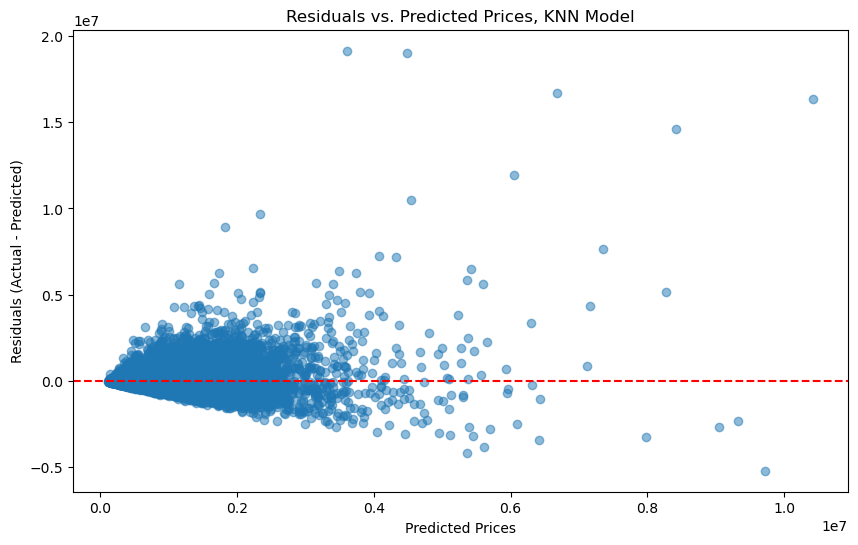

In [21]:
# Compare KNN model at K=10, K value with highest R^2, to simple linear regression

# Plot residuals of KNN model
k = 10
knn_regressor = KNeighborsRegressor(n_neighbors=k)
knn_regressor.fit(X_train, y_train)
y_pred = knn_regressor.predict(X_test)

residuals = y_test - y_pred

plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals, alpha=0.5)
plt.axhline(y=0, color='red', linestyle='--')  #Reference line for zero error
plt.xlabel('Predicted Prices')
plt.ylabel('Residuals (Actual - Predicted)')
plt.title('Residuals vs. Predicted Prices, KNN Model')
plt.show()

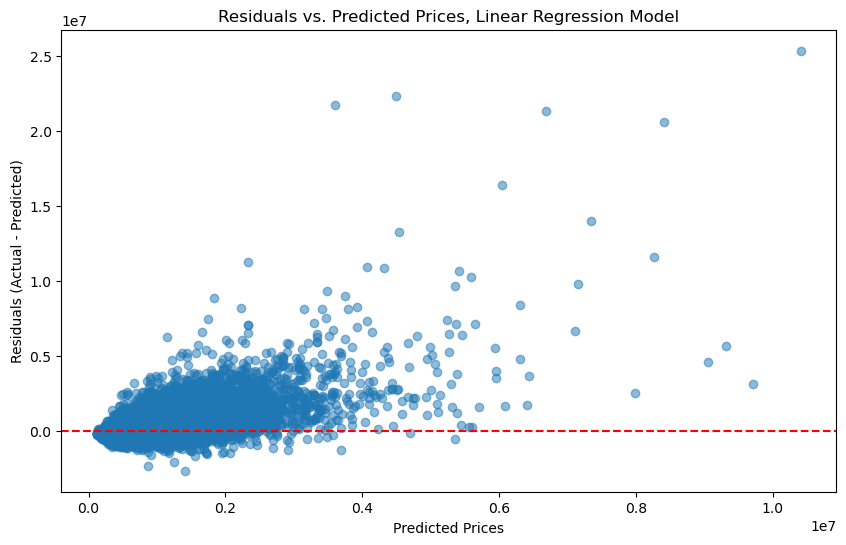

MSE for Simple Linear Regression: 234259868744.89334
R-squared for Simple Linear Regression: 0.1902672635625493
MAE for Simple Linear Regression: 274080.03160148277


In [22]:
# Show summary statistics and plot residuals of simple linear regression

X_train_simple = X_train[['sqft']]
X_test_simple = X_test[['sqft']]
linear_reg = LinearRegression()
linear_reg.fit(X_train_simple, y_train)

y_pred_linear = linear_reg.predict(X_test_simple)

residuals = y_test - y_pred_linear

plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals, alpha=0.5)
plt.axhline(y=0, color='red', linestyle='--')  #Reference line for zero error
plt.xlabel('Predicted Prices')
plt.ylabel('Residuals (Actual - Predicted)')
plt.title('Residuals vs. Predicted Prices, Linear Regression Model')
plt.show()

mse_linear = mean_squared_error(y_test, y_pred_linear)
print(f"MSE for Simple Linear Regression: {mse_linear}")
r2_linear = linear_reg.score(X_test_simple, y_test)
print(f"R-squared for Simple Linear Regression: {r2_linear}")
mae_linear = mean_absolute_error(y_test, y_pred_linear)
print(f"MAE for Simple Linear Regression: {mae_linear}")

Note how the residuals for the KNN model are more symmetrical across the X=0 axis. This is indicative of less bias / better forecasting in the KNN model because the errors are balanced.

A simple linear regression forecasting model with one variable isn't the best competition with the sophistication of the KNN model. A better comparison could be to a linear regression model using additional variables. The following code produces a model with five variables that have the highest correlation with sale price.

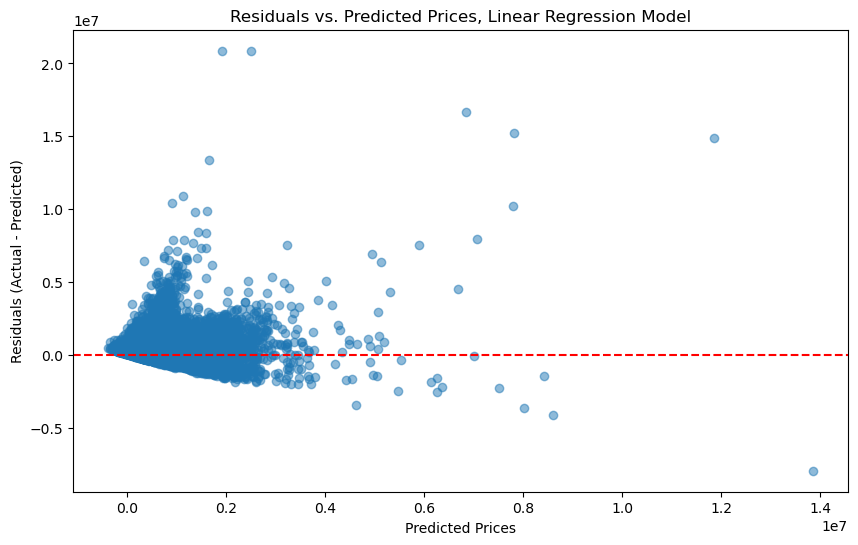

MSE for Linear Regression: 142940519738.20245
R-squared for Linear Regression: 0.5059178560308606
MAE for Linear Regression: 187832.08892339523


In [23]:
# Define the feature set for the linear regression model
features = ['land_val', 'sqft', 'year', 'imp_val', 'grade']

# Prepare the training and testing data with the selected features
X_train_selected = X_train[features]
X_test_selected = X_test[features]

# Initialize and train the linear regression model
linear_reg = LinearRegression()
linear_reg.fit(X_train_selected, y_train)

# Predict sale prices on the test set
y_pred_linear = linear_reg.predict(X_test_selected)

# Calculate residuals
residuals = y_test - y_pred_linear

# Plot residuals
plt.figure(figsize=(10, 6))
plt.scatter(y_pred_linear, residuals, alpha=0.5)
plt.axhline(y=0, color='red', linestyle='--')  # Reference line for zero error
plt.xlabel('Predicted Prices')
plt.ylabel('Residuals (Actual - Predicted)')
plt.title('Residuals vs. Predicted Prices, Linear Regression Model')
plt.show()

# Calculate and print evaluation metrics
mse_linear = mean_squared_error(y_test, y_pred_linear)
print(f"MSE for Linear Regression: {mse_linear}")
r2_linear = linear_reg.score(X_test_selected, y_test)
print(f"R-squared for Linear Regression: {r2_linear}")
mae_linear = mean_absolute_error(y_test, y_pred_linear)
print(f"MAE for Linear Regression: {mae_linear}")

# Conclusion

Even with additional variables added to the linear regression model, the R-squared value of 0.506 is lower than the KNN model of 0.662. The mean absolute error is approximately $40,000 larger. It appears the KNN model is superior to the simpler linear regressions given the dataset. Further work can be done re-performing the analysis with training and validation datasets to compare the models' forecasting capacity over fit.

# Bonus: Sale Price Map

The following code produces a map of the sale price of all sales in the dataset. The map scale has been reduced on the eastern side to focus on the Seattle metro area of King County.

In [24]:
# Filter the DataFrame to exclude longitudes below 121.6
filtered_df = df[df['longitude'] <= -121.6]

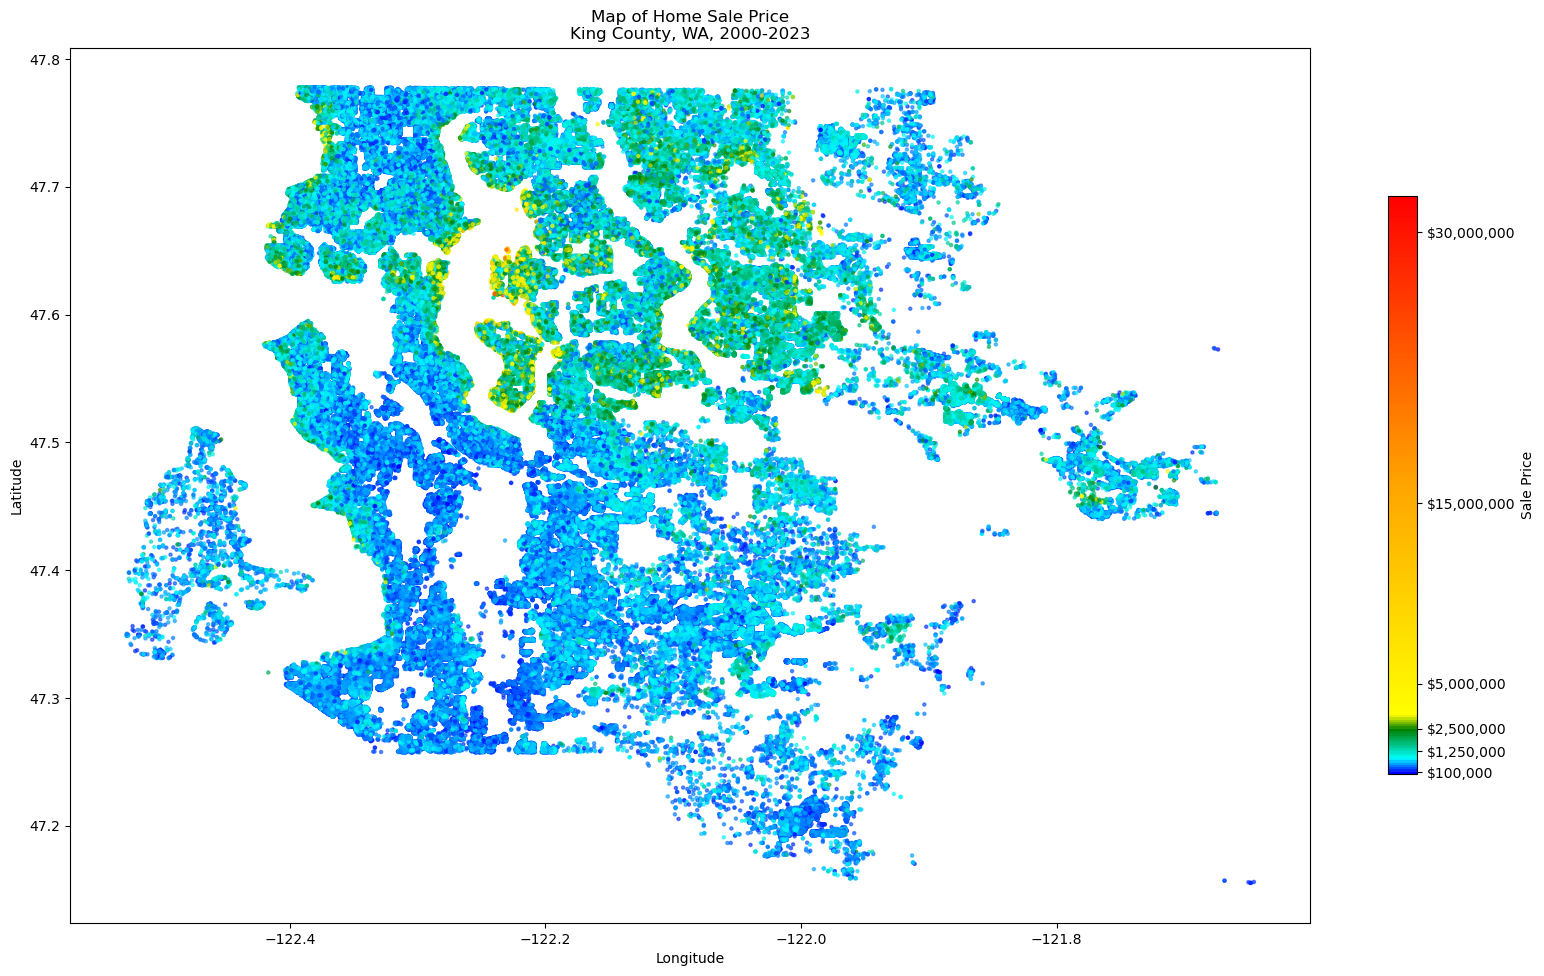

In [25]:
# Ensure dataset has 'latitude', 'longitude', and 'sale_price' columns
if 'latitude' in filtered_df.columns and 'longitude' in filtered_df.columns and 'sale_price' in filtered_df.columns:
    # Create a GeoDataFrame from the DataFrame
    gdf = gpd.GeoDataFrame(filtered_df, geometry=gpd.points_from_xy(filtered_df.longitude, filtered_df.latitude))

    # Define a custom color scale
    custom_colors = [
        (0.0, "blue"),
        (0.025, "cyan"),
        (0.075, "green"),
        (0.1, "yellow"),
        (0.5, "orange"),
        (1.0, "red")
    ]
    custom_cmap = LinearSegmentedColormap.from_list("custom_cmap", custom_colors)

    # Create a plot with a defined size
    fig, ax = plt.subplots(figsize=(20, 15))

    # Plot the data with a custom color gradient based on sale_price
    norm = plt.Normalize(vmin=0, vmax=filtered_df['sale_price'].max())
    gdf.plot(ax=ax, marker='o', markersize=5, column='sale_price', cmap=custom_cmap, alpha=0.6, norm=norm)

    sm = plt.cm.ScalarMappable(cmap=custom_cmap, norm=norm)
    sm._A = []
    cbar = fig.colorbar(sm, ax=ax, shrink=0.5, aspect=20)
    cbar.set_label('Sale Price')
    
    # Set the colorbar ticks and labels in dollars
    cbar_ticks = [100000, 1250000, 2500000, 5000000, 15000000, 30000000]
    cbar.set_ticks(cbar_ticks)
    cbar.set_ticklabels([f'${int(tick):,}' for tick in cbar_ticks])

    # Set plot titles and labels
    plt.title('Map of Home Sale Price\nKing County, WA, 2000-2023')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')

    plt.show()
else:
    print("The 'latitude', 'longitude', and/or 'sale_price' columns do not exist in the DataFrame.")

From the map it can be seen that the waterfront property around Lake Washington has the highest home prices. The area on the eastern side of the lake, Medina, is known to be Bill Gates' neighborhood.